<img src="../images/headers/nb_1.svg"  width="1080" height="220">

The purpose of this notebook is to
1. Import the data
2. Clean the data
3. Export the data

# Table of Contents
- [Import Dataset](#import-dataset)
- [Clean Accident Dataset](#clean-accident-dataset)
- [Clean Vehicles Dataset](#clean-vehicles-dataset)
- [Clean Persons Dataset](#clean-persons-dataset)
- [Merge Datasets](#merge-datasets)
- [Feature Engineering](#feature-engineering)
- [Export Data](#export-data)

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pywaffle import Waffle
import missingno as msno

from roaf import data, visualization

In [2]:
%matplotlib inline
plt.style.use("dark_background")
plt.set_cmap("Dark2")
sns.set_palette("Dark2")

<Figure size 640x480 with 0 Axes>

# Parameters

In [3]:
PLOT_DIR = "../images/figures"
N_PLOT_SAMPLE = None
PLOT_FILE_FORMATS = ["png"]
PLOTTING = True

In [4]:
# Parameters
PLOT_FILE_FORMATS = ["png", "svg"]


# Import Dataset

In [5]:
dfd = data.read_csv_of_year(range(2019, 2022))

# Clean Accident Dataset
The accident dataset will be merged from the datasets *characteristics* and *locations,* as both
have the same key *(accident_id).*

In [6]:
accidents = pd.merge(
    left=dfd["characteristics"],
    right=dfd["locations"],
    how="outer",
    left_on="Num_Acc",
    right_on="Num_Acc",
    validate="one_to_one",
    indicator=True,
)

# Check
accidents["_merge"].value_counts()

both          163102
left_only          0
right_only         0
Name: _merge, dtype: int64

## Translation of French Variable Names

In [7]:
accidents.rename(
    columns={
        "Num_Acc": "accident_id",
        "an": "year",  # Characteristics Dataset
        "mois": "month",
        "jour": "day",
        "hrmn": "hhmm",
        "lum": "daylight",
        "agg": "built_up_area",
        "int": "intersection_category",
        "atm": "weather",
        "col": "collision_category",
        "com": "municipality",
        "adr": "address",
        "gps": "gps_origin",
        "lat": "latitude",
        "long": "longitude",
        "dep": "department",
        "catr": "road_admin_category",  # Locations Dataset
        "voie": "road_number",
        "v1": "road_numerical_id",
        "v2": "road_alphanumerical_id",
        "circ": "traffic_regime",
        "nbv": "n_lanes",
        "pr": "landmark",
        "pr1": "dist_to_landmark",
        "vosp": "reserved_lane",
        "prof": "slope",
        "plan": "plane_layout",
        "lartpc": "median_strip_width",
        "larrout": "affected_road_width",
        "surf": "surface_condition",
        "infra": "infrastructure",
        "situ": "location",
        "env1": "near_school",
        "vma": "max_speed",
    },
    inplace=True,
)

## Display of a sample

In [8]:
accidents.sample(20).T

,129006,61019,131390,127069,38745,105506,102329,22803,84177,54084,67252,113330,92489,27224,96632,106414,162136,70067,116628,5316
accident_id,202100022423,202000002180,202100024807,202100020486,201900038746,202000046667,202000043490,201900022804,202000025338,201900054085,202000008413,202100006747,202000033650,201900027225,202000037793,202000047575,202100055553,202000011228,202100010045,201900005317
day,26,3,10,6,2,27,12,9,6,20,30,20,28,6,26,22,10,13,31,26
month,8,2,8,9,10,8,5,9,6,8,11,11,9,5,9,5,1,9,10,11
year,2021,2020,2021,2021,2019,2020,2020,2019,2020,2019,2020,2021,2020,2019,2020,2020,2021,2020,2021,2019
hhmm,17:20,05:15,17:13,15:20,17:30,06:40,03:00,16:00,18:55,12:35,11:15,01:00,10:30,13:50,09:25,15:13,02:20,12:10,15:40,17:15
daylight,1,5,1,1,1,2,3,1,5,1,1,3,1,1,1,1,5,1,1,5
department,64,70,85,69,14,26,91,93,971,69,35,01,91,59,93,83,92,78,75,92
municipality,64545,70011,85004,69381,14118,26271,91207,93070,97113,69259,35278,01353,91201,59122,93010,83070,92046,78490,75103,92035
built_up_area,2,2,1,2,2,1,1,2,2,1,1,1,2,2,2,2,2,2,2,2
intersection_category,1,1,3,1,6,1,1,1,9,9,1,4,6,1,2,1,2,1,4,9


From displaying a small sample of accidents it is visible that the address is not standardized
(as mentioned in the documentation). Given that GPS data is available, the address will probably
not be of any value.

It is also visible that there are parentheses in *landmark* and *dist_to_landmark.*

## Analysis of missing values
In order to get an understanding of the missing values, the missingno package will be used.
This package provides a couple of useful plots that visualize the number of missing values as
well as the relationship between missing values of different variables.

In most cases, the missing values have to be identified and converted, as they are encoded
with -1.

In [9]:
# Convert Variables with -1 and empty strings for missing values
accidents.replace(to_replace=[-1, ""], value=np.nan, inplace=True)

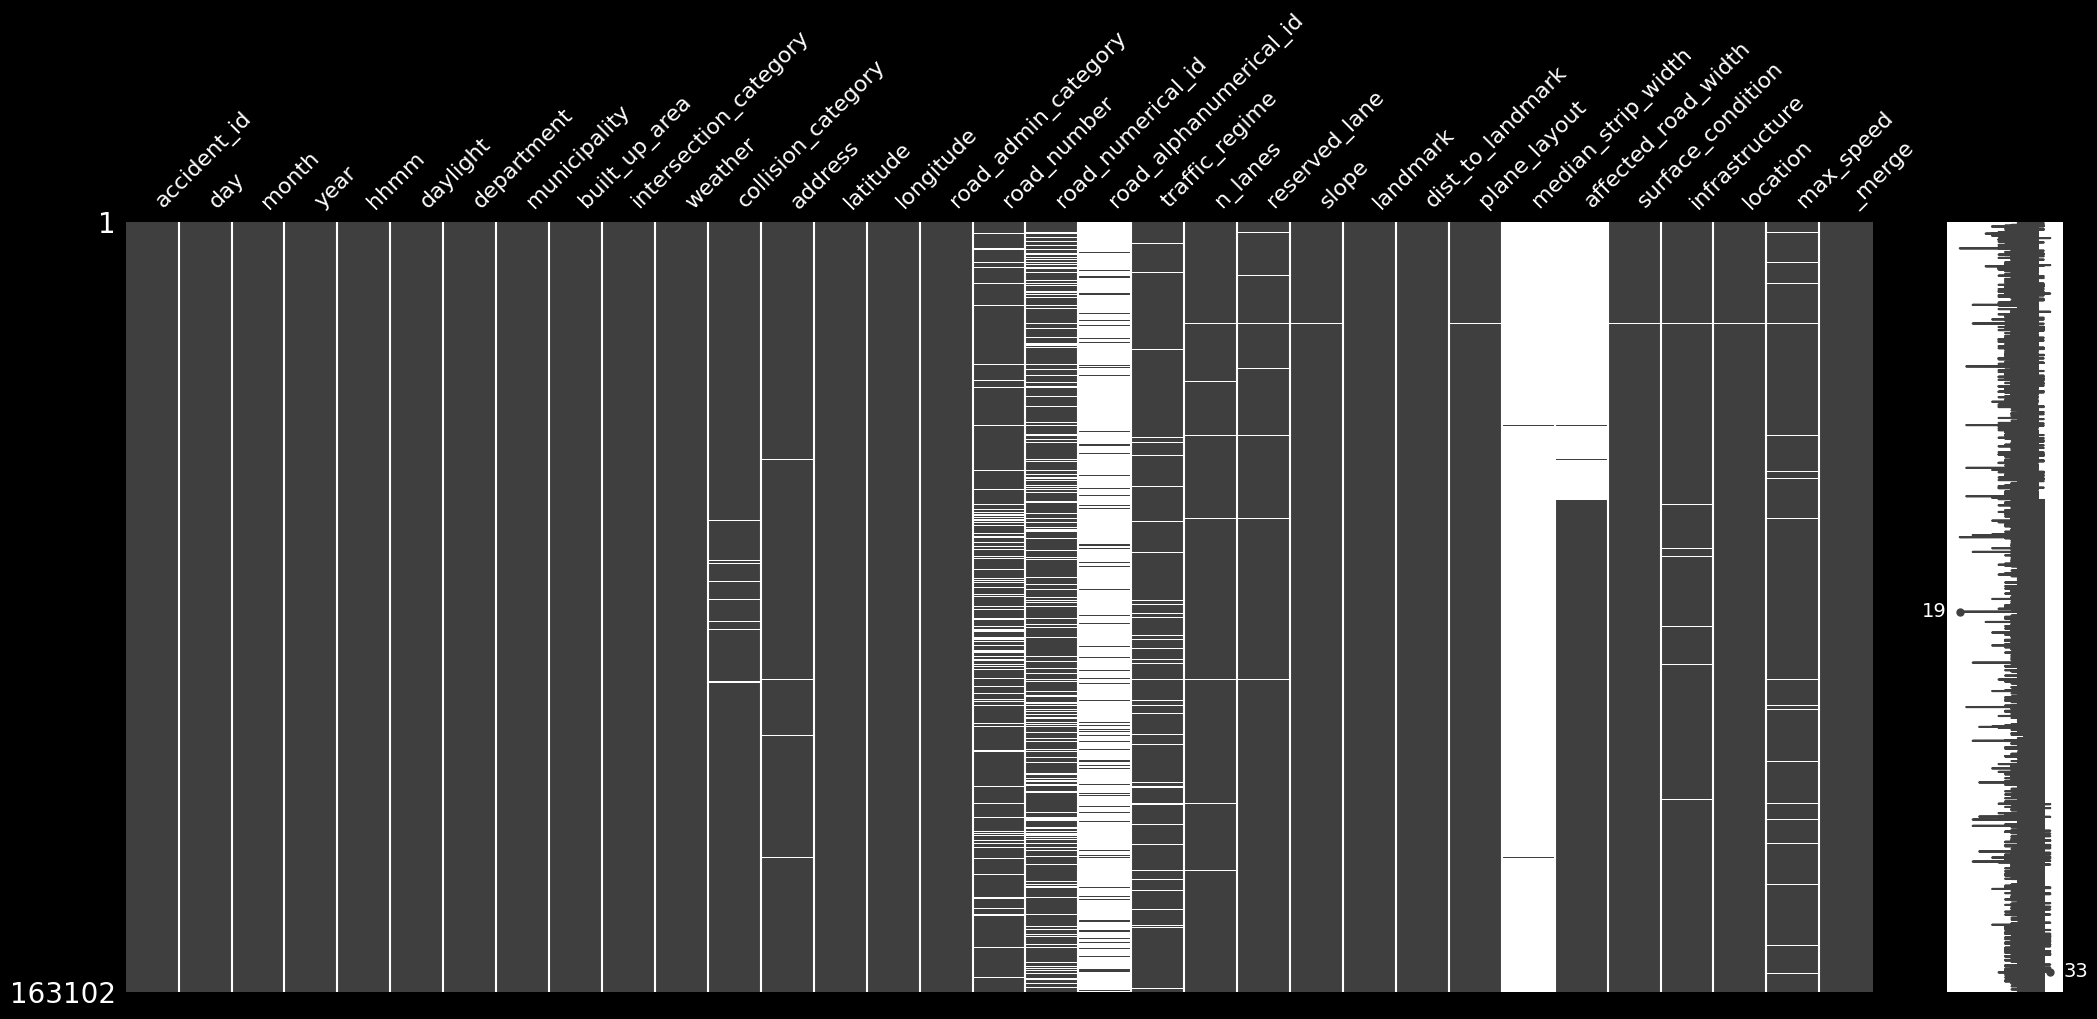

In [10]:
if PLOTTING:
    msno.matrix(accidents)
    visualization.savefig(
        basename="msno_matrix_accidents", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
    )

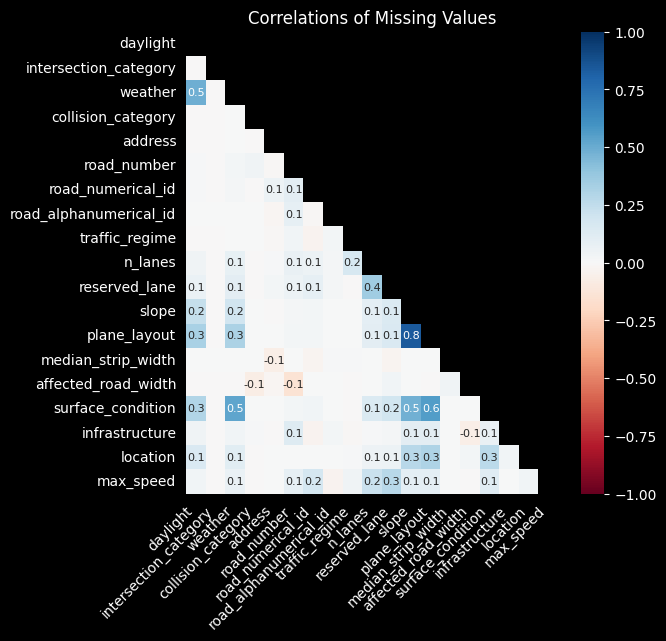

In [11]:
if PLOTTING:
    msno.heatmap(accidents, figsize=(6, 6), fontsize=10)
    plt.title("Correlations of Missing Values")
    visualization.savefig(
        basename="msno_heat_accidents", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
    )

In [12]:
def na_stats(df, years=None):
    """Compute the number and ratio of missing values for the specified years.
    If no years are specified, the stats for all years will be computed.
    """
    if (years is None) & ("year" in df.columns):
        years = range(df["year"].min(), df["year"].max() + 1)

    if isinstance(years, int):
        years = [years]

    if years is not None:
        df = df[df["year"].isin(years)]

    na_stats_df = pd.DataFrame(df.isna().sum(), columns=["na_counts"])
    inverse_n_rows = 1 / len(df)
    na_stats_df["na_ratio"] = na_stats_df["na_counts"].apply(
        lambda x: x * inverse_n_rows
    )
    na_stats_df.rename_axis("variable", inplace=True)
    na_stats_df = na_stats_df[na_stats_df["na_counts"] != 0]
    na_stats_df.sort_values(by="na_counts", ascending=False, inplace=True)
    return na_stats_df


def plot_na_ratio(df=None, na_stats_df=None, years=None):
    """Plot the ratio of missing values for the specified years."""
    if (na_stats_df is not None) & (df is not None):
        raise ValueError("Only one argument of df and na_stats can be used.")
    if (na_stats_df is None) & (df is not None):
        na_stats_df = na_stats(df, years=years)

    sns.barplot(data=na_stats_df, x="na_ratio", y=na_stats_df.index)
    plt.title("Ratio of Missing Values")
    plt.ylabel("Variable Name")
    plt.xlabel("Ratio of Missing Values")
    return na_stats_df

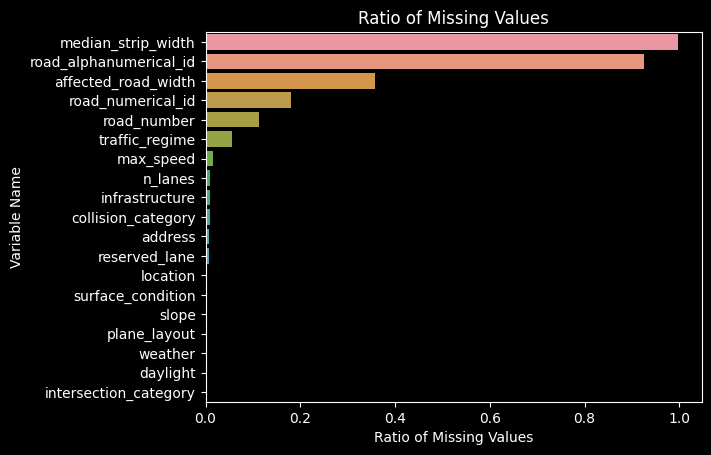

In [13]:
if PLOTTING:
    plot_na_ratio(df=accidents, years=range(2019, 2022))

The plots show that the affected_road_with variable seems to come into existence only after one
year, while a small number of values exists before.

The road_numerical_id has a lot of values missing also in the first third of the dataset.
It is possible that the definition of this variable changed at that point and that the values
are not completely comparable before and after the change.

The alphanumerical id of the road is missing in nearly all cases. It will probably not be
beneficial to keep this variable.

The correlation plot shows that similar variables are more likely to share missing values.
The variables *plane layout* and *slope* are correlated the most, and both describe the
topology of the accident. I assume that missing values mean that the accident happened on a flat
and straight road.

In [14]:
# Backfill
backfill_cols = [
    "daylight",
    "intersection_category",
    "traffic_regime",
    "reserved_lane",
    "plane_layout",
    "surface_condition",
    "infrastructure",
    "location",
]
accidents.loc[:, backfill_cols] = accidents.loc[:, backfill_cols].fillna(method="bfill")

In [15]:
# The columns median_strip_width, affected_road_width and road_numerical_id are missing a
# lot of values, so they will be dropped.
accidents.drop(
    columns=["median_strip_width", "affected_road_width", "road_numerical_id"],
    inplace=True,
)

## Time and Date-Related Variables

In [16]:
# Fix inconsistent year format
accidents["year"].replace(
    {
        5: 2005,
        6: 2006,
        7: 2007,
        8: 2008,
        9: 2009,
        10: 2010,
        11: 2011,
        12: 2012,
        13: 2013,
        14: 2014,
        15: 2015,
        16: 2016,
        17: 2017,
        18: 2018,
    },
    inplace=True,
)

# Fix inconsistent time format
accidents["hhmm"] = accidents["hhmm"].apply(lambda s: str(s).replace(":", ""))

accidents["hour"] = accidents["hhmm"].apply(lambda hhmm: hhmm[:-2])
accidents["hour"] = accidents["hour"].replace("", np.nan).fillna(method="bfill")
accidents["minute"] = accidents["hhmm"].apply(lambda hhmm: hhmm[-2:])

accidents["date"] = pd.to_datetime(
    {
        "year": accidents["year"],
        "month": accidents["month"],
        "day": accidents["day"],
        "hour": accidents["hour"],
        "minute": accidents["minute"],
    }
)

# New variable: weekday, integer from 0 to 6 representing the weekdays from monday to sunday.
accidents["day_of_week"] = accidents["date"].apply(lambda x: x.day_of_week)

# New binary variable: is_weekend, 0 for monday to friday and 1 for saturday and sunday
accidents["is_weekend"] = (accidents["day_of_week"] > 4).astype("int")

# The hhmm variable will be used in its integer representation for plotting in nb 2
accidents["hhmm"] = accidents["hhmm"].astype("int")

## Department Variable
The department is numerically encoded, but they don't exactly match the
*Code officiel géographique*
(COG).

In [17]:
def department_converter(dep):
    """
    Takes in a department code as int and returns a string
    e.g. 750 will be '75' for Paris and 201 will be '2B'
    """
    if dep == 201:
        return "2A"
    elif dep == 202:
        return "2B"
    elif dep > 970:
        return str(dep)
    else:
        return str(dep).strip("0")


accidents.loc[(np.less(accidents["year"], 2019)), "department"] = accidents[
    (np.less(accidents["year"], 2019))
]["department"].apply(department_converter)

## GPS-Data

In [18]:
# Replace commas with periods in GPS Data
accidents["latitude"] = (
    accidents["latitude"].apply(lambda x: x.replace(",", ".")).astype("float")
)
accidents["longitude"] = (
    accidents["longitude"].apply(lambda x: x.replace(",", ".")).astype("float")
)

In [19]:
# Now I can check if there are some values equal to zero, which can be an indicator for missing
# values
for this_var in ["latitude", "longitude"]:
    print(this_var, (accidents[this_var] == 0.0).sum())

latitude 0
longitude 0


In [20]:
# Convert to Web Mercator Projection
accidents = data.df_geotransform(df=accidents)

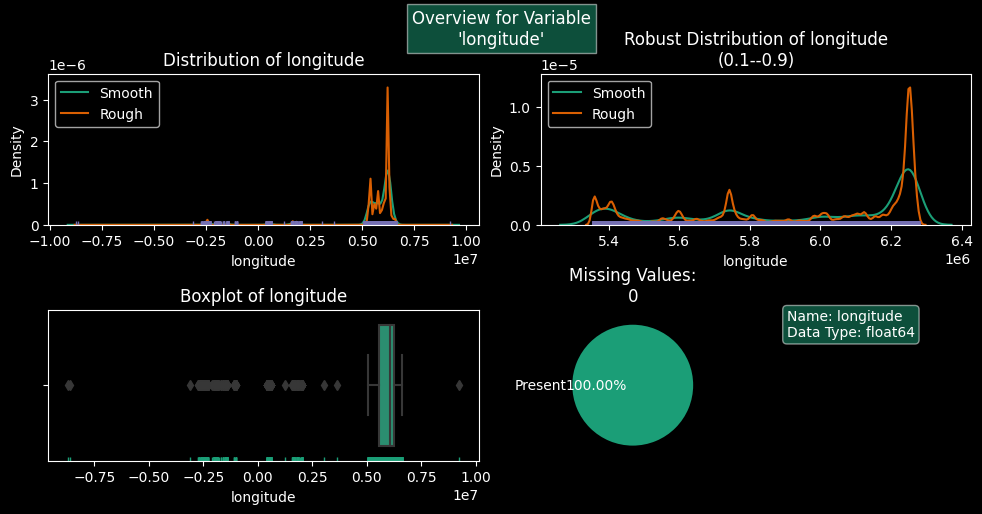

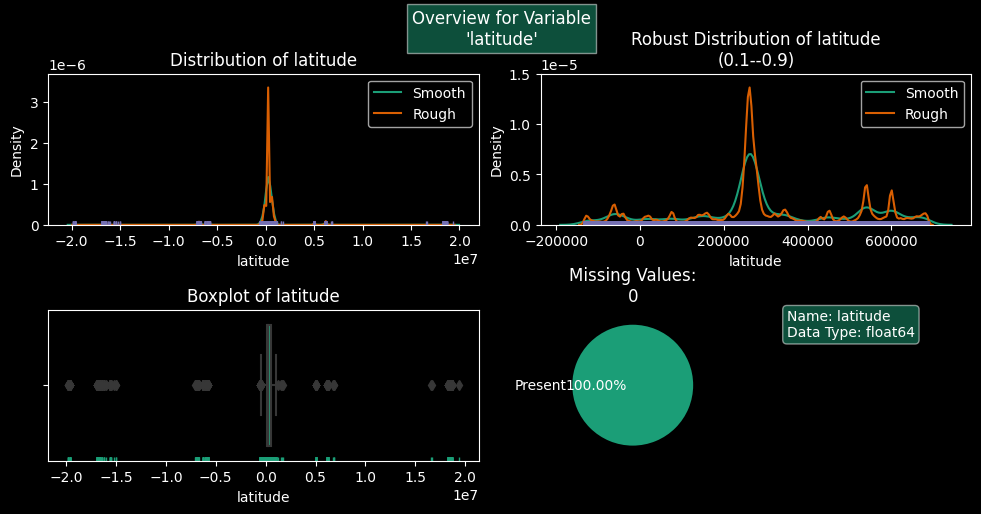

In [21]:
# Longitude
if PLOTTING:
    visualization.plot_continuous_variable_overview(
        accidents, "longitude", filter_percentile=0.1
    )

    # Saving (exporting svg can take a lot time)
    visualization.savefig(
        basename="overview_longitude", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
    )

    # Latitude
    visualization.plot_continuous_variable_overview(
        accidents, "latitude", filter_percentile=0.1
    )

    # Saving (exporting svg can take a lot time)
    visualization.savefig(
        basename="overview_latitude", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
    )

Plotting the distribution of latitude and longitude we can see that there is one very dense
regions and some outlier regions. This shows that the dataset does not only contain the data from
mainland France, but also from the overseas.

## Other variables

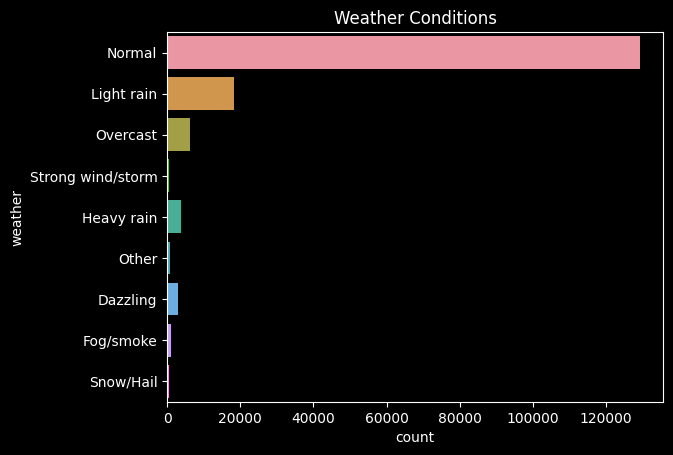

In [22]:
weather_dict = {
    1: "Normal",
    2: "Light rain",
    3: "Heavy rain",
    4: "Snow/Hail",
    5: "Fog/smoke",
    6: "Strong wind/storm",
    7: "Dazzling",
    8: "Overcast",
    9: "Other",
}

if PLOTTING:
    sns.countplot(y=accidents["weather"].replace(weather_dict))
    plt.title("Weather Conditions")
    visualization.savefig(
        basename="hist_weather", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
    )

In [23]:
accidents["weather"] = accidents["weather"].fillna(accidents["weather"].mode()[0])
accidents["weather"].replace({-1, 0}, inplace=True)
accidents["weather"] = accidents["weather"].astype("int")

In [24]:
accidents["collision_category"] = accidents["collision_category"].fillna(
    accidents["collision_category"].mode()[0]
)

In [25]:
accidents["built_up_area"].replace({1: 0, 2: 1}, inplace=True)

## Max  Speed

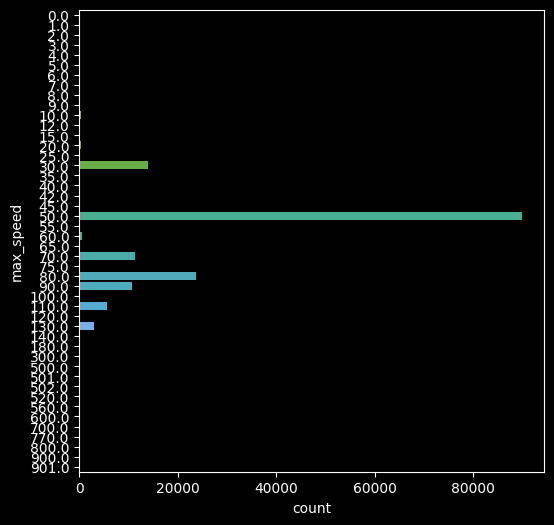

In [26]:
if PLOTTING:
    plt.figure(figsize=(6, 6))
    sns.countplot(data=accidents, y="max_speed")

Plotting the maximum speed shows that there are some irrational values.
I will replace the ones where I think there are too many zeros and leave the
rest as it is for now.

In [27]:
accidents["max_speed"].replace(
    {300: 30, 500: 50, 700: 70, 800: 80, 900: 90}, inplace=True
)

# Clean Vehicles Dataset
Another dataset is available which contains more additional information, but will not be used
here.
The reason is that it contains only information about accidents with hurt or killed people, which
means that (1) there are a lot of missing values and (2) the presence of this data could easily
lead to leaking in machine learning.

In [28]:
dfd["vehicles"].rename(
    columns={
        "Num_Acc": "accident_id",
        "id_vehicule": "unique_vehicle_id",
        "num_veh": "vehicle_id",
        "senc": "direction",
        "catv": "vehicle_category",
        "obs": "immobile_obstacle",
        "obsm": "mobile_obstacle",
        "choc": "impact_point",
        "manv": "last_operation",
        "motor": "motor_type",
        "occutc": "n_occupants",
    },
    inplace=True,
)

In [29]:
dfd["vehicles"].sample(20).T

,278548,139861,187527,177971,246656,212459,276876,30298,75151,918,211383,9868,28611,258478,79897,113973,19909,230720,112625,119509
accident_id,202100056197,202000023028,202100003395,202000045519,202100037619,202100017810,202100055188,201900017763,201900043915,201900000551,202100017197,201900005762,201900016769,202100044507,201900046641,202000007786,201900011671,202100028428,202000007013,202000011059
unique_vehicle_id,101 441,154 701 710,195 691,154 662 259,134 413,169 785,103 168,138 273 220,138 223 625,138 305 520,170 896,138 295 704,138 275 107,122 149,138 218 299,154 728 547,138 284 773,150 902,154 729 931,154 722 817
vehicle_id,A01,B01,A01,A01,B01,A01,A01,B01,A01,A01,A01,A01,A01,A01,B01,A01,B01,A01,A01,B01
direction,1,1,3,2,1,3,1,3,1,1,3,1,1,1,1,2,1,2,0,2
vehicle_category,7,2,7,37,7,7,7,7,7,7,7,3,33,7,30,30,7,7,7,7
immobile_obstacle,0,0,0,0,0,1,0,0,0,4,2,0,0,0,0,0,0,0,0,3
mobile_obstacle,2,2,2,2,2,0,2,2,6,0,0,1,6,5,2,2,2,2,1,2
impact_point,7,1,1,5,1,2,9,3,2,5,1,1,1,1,1,1,4,6,1,1
last_operation,12,1,2,1,1,1,14,15,1,1,1,9,1,1,0,1,9,24,1,2
motor_type,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1


## Analysis of Missing Values

In [30]:
# Missing values are assigned the vale -1 in the original dataset
dfd["vehicles"].replace({-1: np.nan}, inplace=True)
na_stats(dfd["vehicles"])

,na_counts,na_ratio
variable,,
n_occupants,276834,0.991913
direction,1000,0.003583
motor_type,694,0.002487
mobile_obstacle,151,0.000541
impact_point,132,0.000473
last_operation,104,0.000373
immobile_obstacle,96,0.000344
vehicle_category,9,0.000032


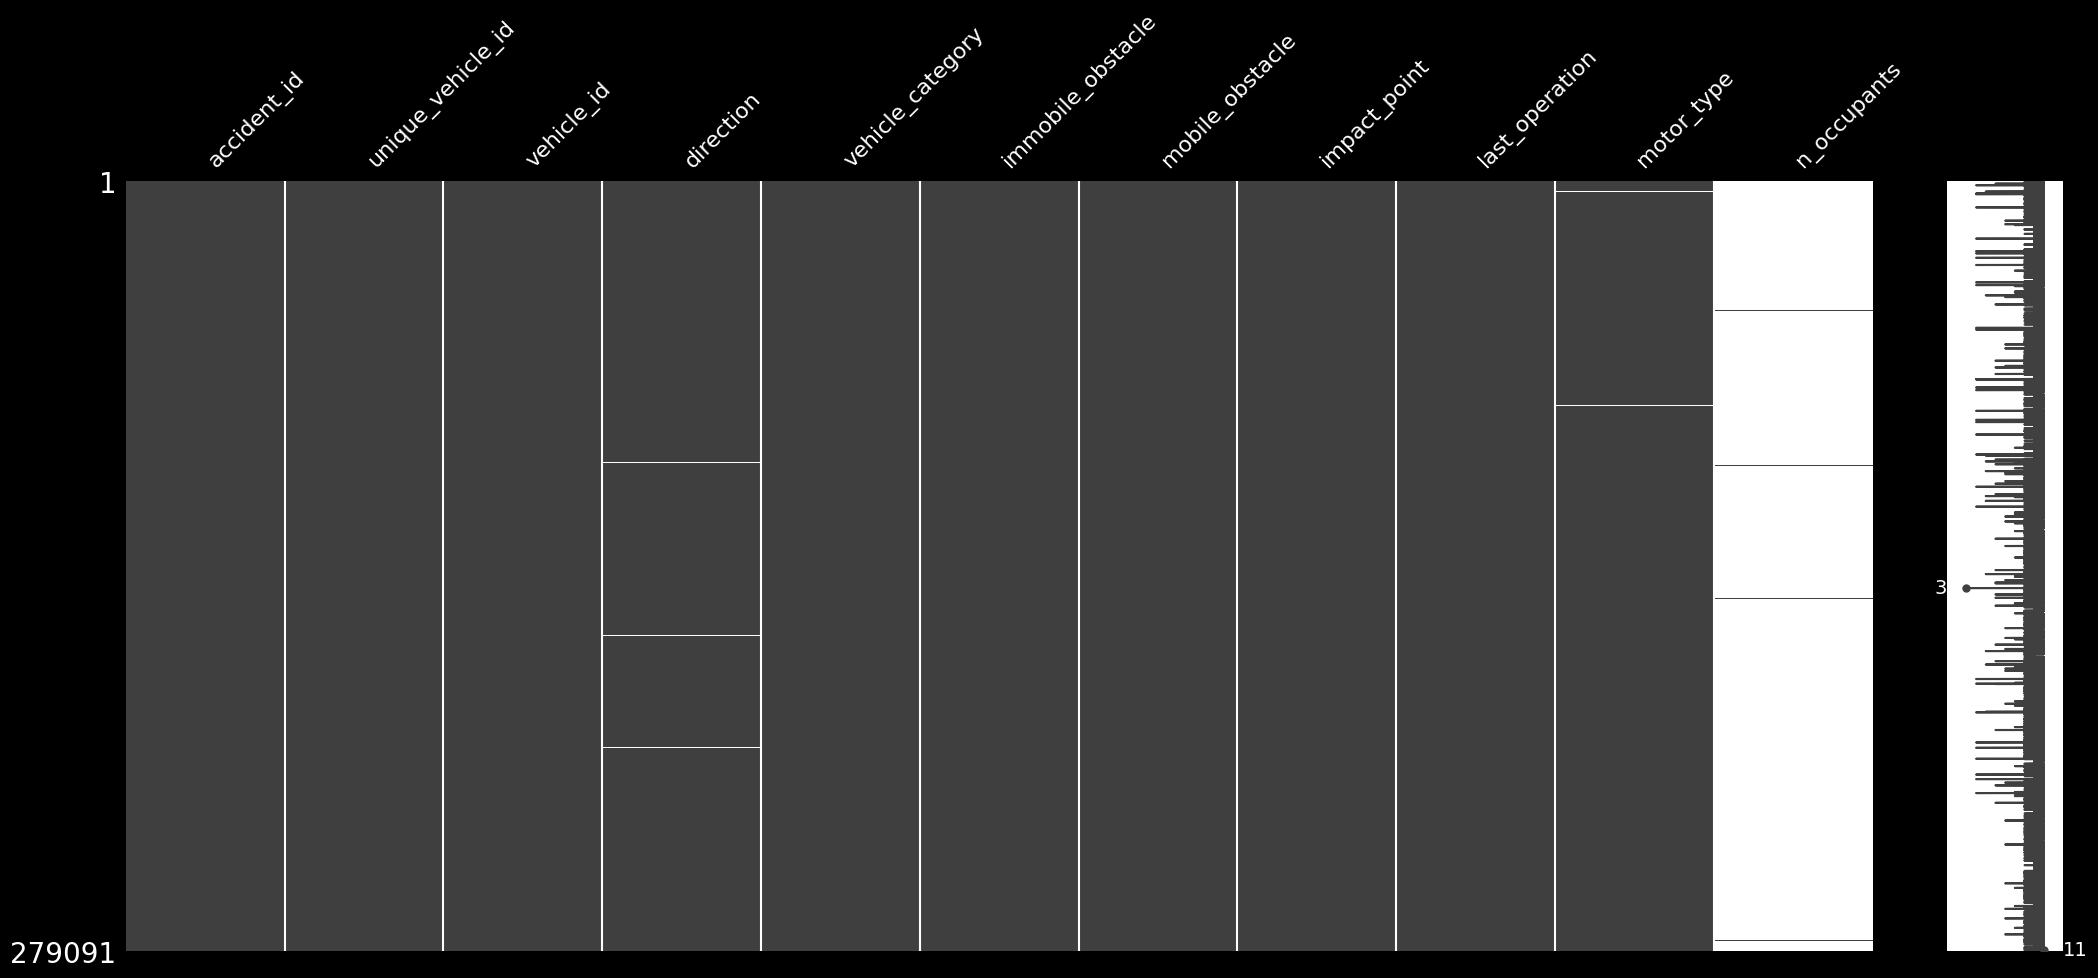

In [31]:
if PLOTTING:
    msno.matrix(dfd["vehicles"])
    visualization.savefig(
        basename="msno_matrix_vehicles", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
    )

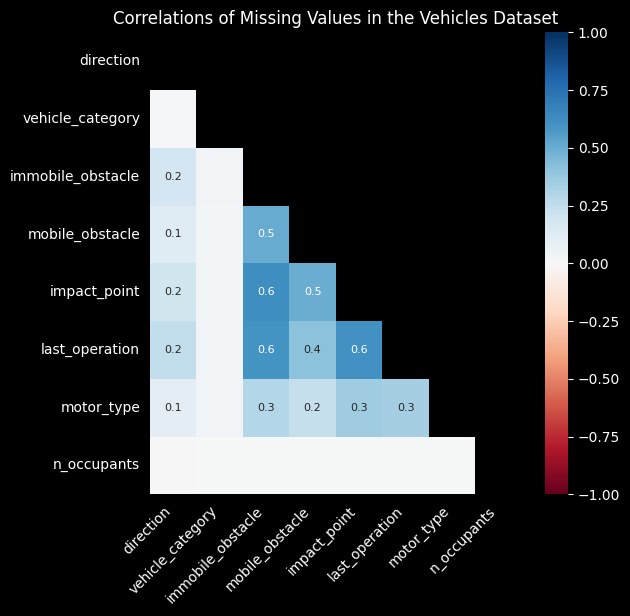

In [32]:
if PLOTTING:
    msno.heatmap(dfd["vehicles"], figsize=(6, 6), fontsize=10)
    plt.title("Correlations of Missing Values in the Vehicles Dataset")
    visualization.savefig(
        basename="msno_heat_vehicles", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
    )

For n_occupants, almost all values are missing. This is logical, since it is only used for
means of public transport.

## Cleaning of *vehicle_id*

In [33]:
# Every single vehicle Id ends with '01', so we can get rid of it
print(dfd["vehicles"]["vehicle_id"].apply(lambda x: x[-2:]).value_counts())
dfd["vehicles"]["vehicle_id"] = dfd["vehicles"]["vehicle_id"].apply(lambda x: x[:-2])

01    279091
Name: vehicle_id, dtype: int64


In [34]:
# Let's see how many values are not alphabetically encoded 8after removing the numeric part)
vehicle_id_az = dfd["vehicles"]["vehicle_id"].apply(
    lambda x: re.search(pattern="[^A-Z]", string=x)
)
for i_match, this_match in enumerate(vehicle_id_az):
    try:
        vehicle_id_az[i_match] = this_match.group(0)
    except AttributeError:
        pass
vehicle_id_az.value_counts()

[    9
\    1
]    1
Name: vehicle_id, dtype: int64

In [35]:
dfd["vehicles"]["vehicle_id"] = dfd["vehicles"]["vehicle_id"].replace(
    dict.fromkeys(["[", "]", "\\"], np.nan)
)
dfd["vehicles"].isna().sum()

accident_id               0
unique_vehicle_id         0
vehicle_id               11
direction              1000
vehicle_category          9
immobile_obstacle        96
mobile_obstacle         151
impact_point            132
last_operation          104
motor_type              694
n_occupants          276834
dtype: int64

As a possible improvement the missing values fo vehicle_id could be inferred from the other
vehicle ids. # This is not done here, because the variable is possibly not necessary because of
the existence of unique_vehicle_id.

# Clean Persons Dataset

In [36]:
dfd["persons"].rename(
    columns={
        "Num_Acc": "accident_id",
        "id_vehicule": "unique_vehicle_id",
        "num_veh": "vehicle_id",
        "place": "seat",
        "catu": "role",
        "grav": "severity",
        "sexe": "sex",
        "an_nais": "year_of_birth",
        "trajet": "objective",
        "secu1": "safety_1",
        "secu2": "safety_2",
        "secu3": "safety_3",
        "locp": "pedestrian_location",
        "actp": "pedestrian_action",
        "etatp": "pedestrian_company",
    },
    inplace=True,
)

## Analysis of missing values

In [37]:
# Missing values are assigned the vale -1 in the original dataset
dfd["persons"].replace({-1: np.nan}, inplace=True)
na_stats(dfd["persons"])

,na_counts,na_ratio
variable,,
safety_3,363199,0.988498
pedestrian_company,339004,0.922648
pedestrian_location,165644,0.450824
safety_2,134830,0.366959
objective,4026,0.010957
year_of_birth,3067,0.008347
sex,3062,0.008334
safety_1,2912,0.007925
severity,60,0.000163


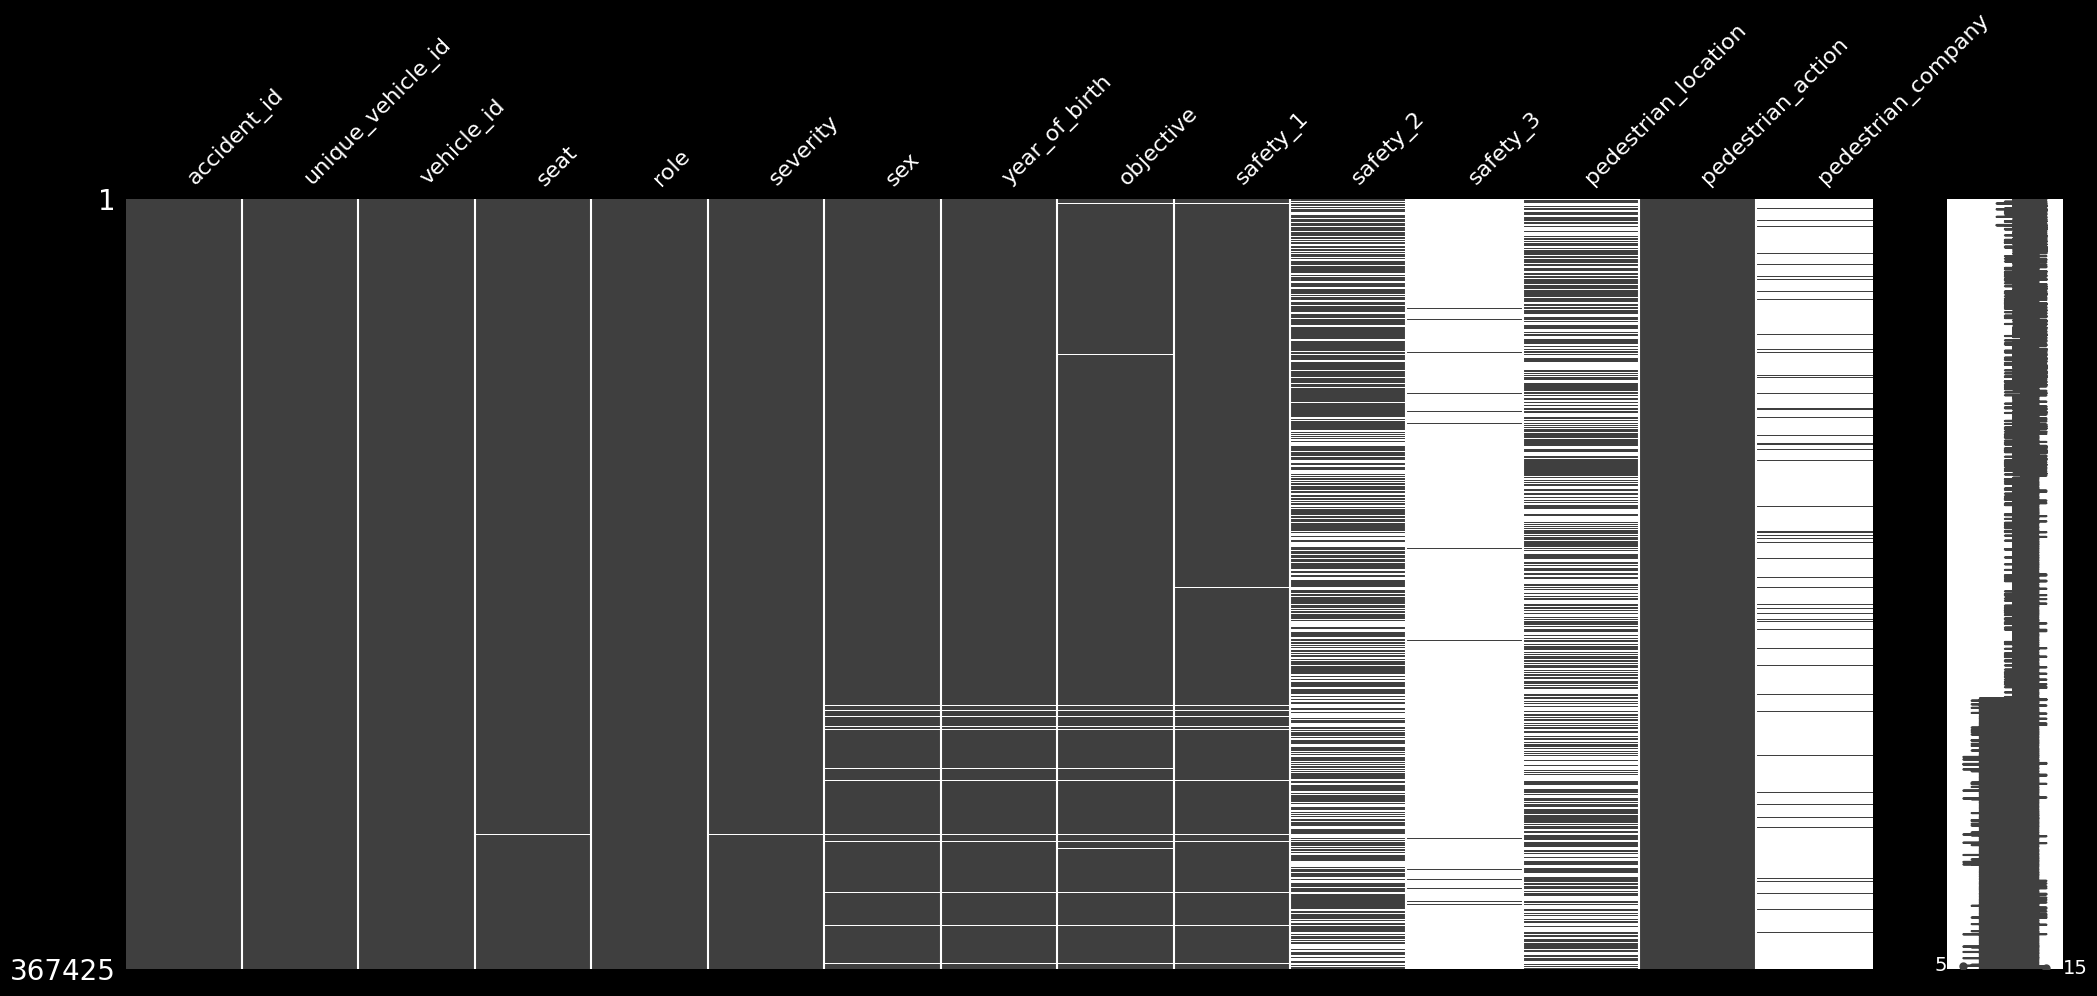

In [38]:
if PLOTTING:
    msno.matrix(dfd["persons"])
    visualization.savefig(basename="msno_matrix_persons", filepath=PLOT_DIR)

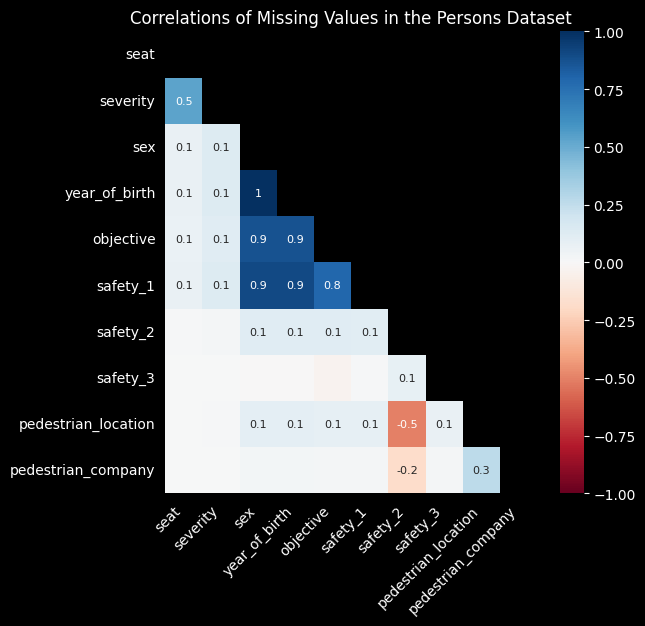

In [39]:
if PLOTTING:
    msno.heatmap(dfd["persons"], figsize=(6, 6), fontsize=10)
    plt.title("Correlations of Missing Values in the Persons Dataset")
    visualization.savefig(
        basename="msno_heat_persons", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
    )

In [40]:
# Missing values are assigned the vale -1 in the original dataset
dfd["persons"].replace({-1: np.nan}, inplace=True)
na_stats(dfd["persons"])

,na_counts,na_ratio
variable,,
safety_3,363199,0.988498
pedestrian_company,339004,0.922648
pedestrian_location,165644,0.450824
safety_2,134830,0.366959
objective,4026,0.010957
year_of_birth,3067,0.008347
sex,3062,0.008334
safety_1,2912,0.007925
severity,60,0.000163


The variables *sex* and *year_of_birth* start having some missing values in 2021.
This is due to a change in data collection: From 2021 on, the database also contains
hit-and-run accidents.
Accidents of this kind will be removed to make the dataset coherent.
This removal has to take place after the merge.

## Processing of safety equipment variables
The safety equipment data is spread across 3 variables (safety_1, safety_2 and safety_3).

In [41]:
dfd["persons"][["safety_1", "safety_2", "safety_3"]].apply(
    lambda col: col.value_counts(dropna=False), axis=0
)

,safety_1,safety_2,safety_3
0.0,28989,146876,1102
1.0,218344,670,21
2.0,68650,739,7
3.0,2384,383,5
4.0,232,3363,51
5.0,194,4560,19
6.0,302,33212,190
7.0,10,505,8
8.0,44988,41228,164
9.0,420,1059,2659


In [42]:
dfd["persons"] = pd.get_dummies(
    dfd["persons"], columns=["safety_1", "safety_2", "safety_3"], prefix="safety"
)
dfd["persons"] = dfd["persons"].groupby(level=0, axis=1).sum()

## Severity
The severity is the most important variable, as it will be the target variable for
machine learning.

In the original database, the severity is encoded as
*(OLD ORDER)*
1 - Unharmed
2 - Killed
3 - Hospitalized
4 - Minor injury

The "hospitalized" indicator is no longer labelled by the public statistics authority as of 2019
[(source)](https://www.data.gouv.fr/en/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/#description). # pylint: disable=C0301
Therefore, the 'injured' categories will be merged.

For the machine learning classifier provided by the XGBoost package, the classes have to start
from 0.

The severity categories will also be reordered to make the order more logical:
*(NEW ORDER)*
0 - Unharmed
1 - Injured
2 - Killed

In [43]:
dfd["persons"]["severity"].replace({1: 0, 3: 1, 4: 1}, inplace=True)
dfd["persons"]["severity"].fillna(0, inplace=True)
dfd["persons"]["severity"] = dfd["persons"]["severity"].astype("int")

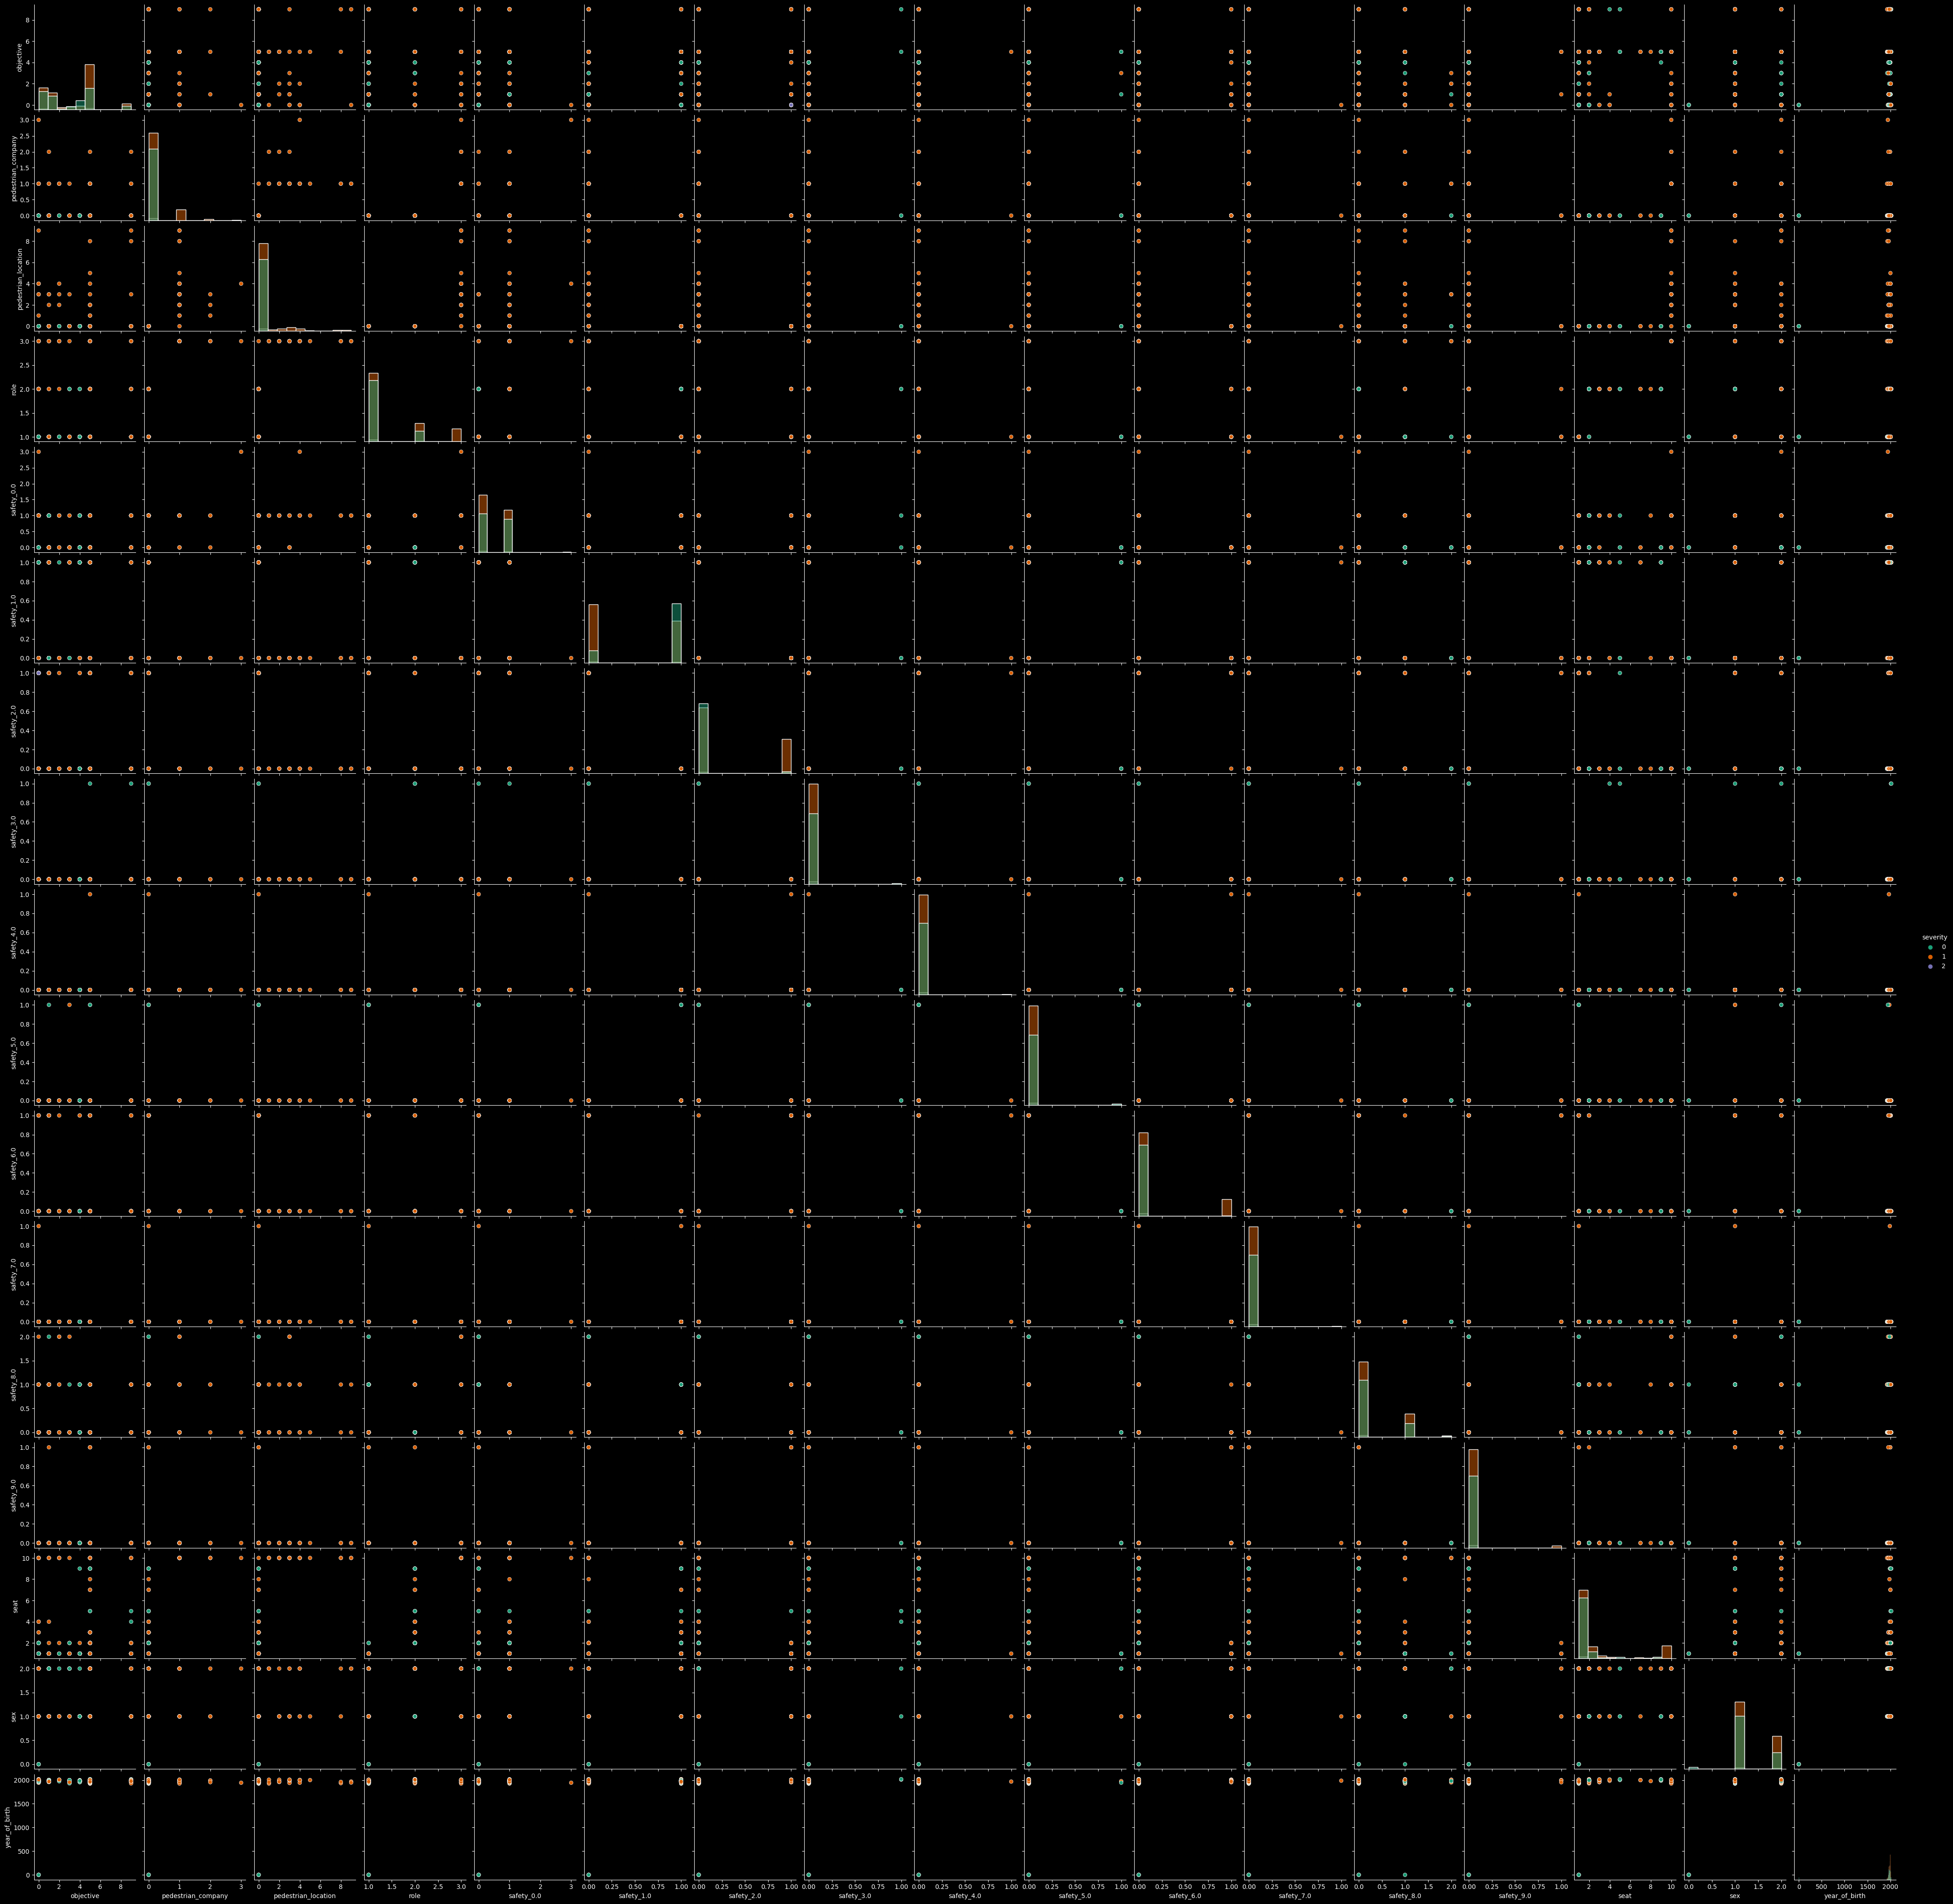

In [44]:
if PLOTTING:
    persons_sample = dfd["persons"].sample(frac=0.001, random_state=0)
    persons_features = (
        persons_sample.select_dtypes(include=np.number)
        .drop(columns=["severity", "accident_id"])
        .columns
    )
    sns.pairplot(
        data=persons_sample,
        vars=persons_features,
        hue="severity",
        diag_kind="hist",
        palette="Dark2",
    )
    visualization.savefig(
        basename="persons_pairplot", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
    )

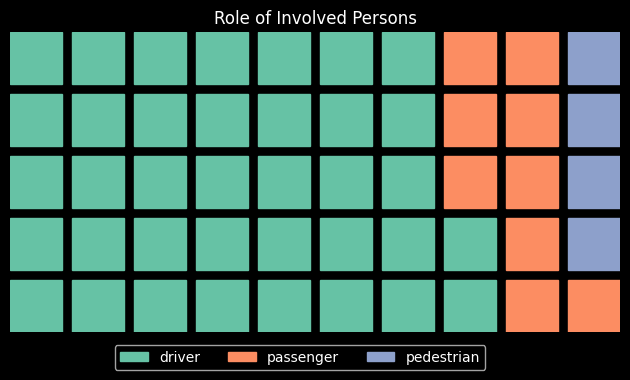

In [45]:
if PLOTTING:
    fig = plt.figure(
        FigureClass=Waffle,
        rows=5,
        columns=10,
        values=dfd["persons"]["role"].value_counts().sort_index(),
        labels=["driver", "passenger", "pedestrian"],
        legend={"loc": "lower left", "bbox_to_anchor": (0.16, -0.15), "ncol": 3},
        title={"label": "Role of Involved Persons"},
    )
    visualization.savefig(
        basename="role_waffle", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
    )

In [46]:
# The variable pedestrian_company has a high number of missing values.
# This is mostly due to the fact that the number of pedestrians is relatively low
dfd["persons"]["pedestrian_company"][dfd["persons"]["role"] == 3].value_counts(
    dropna=False
)

1.0    21640
2.0     5650
3.0     1130
0.0      562
Name: pedestrian_company, dtype: int64

Most of the pedestrians were alone and the missing values are much lower if we only take the
pedestrians into account. I can therefore assume that the missing values are mostly '1',
if the person is a passenger. The rest will be set to zero.

In [47]:
dfd["persons"].loc[dfd["persons"]["role"] == 3, "pedestrian_company"] = dfd["persons"][
    "pedestrian_company"
][dfd["persons"]["role"] == 3].fillna(1)
dfd["persons"].loc[dfd["persons"]["role"] != 3, "pedestrian_company"] = dfd["persons"][
    "pedestrian_company"
][dfd["persons"]["role"] != 3].fillna(0)

# Merge A: Keeping the information for all persons involved
First, the 'vehicles' and 'persons' dataframes have to be merged on 'unique_vehicle_id'.
Then, this new dataframe will be merged with the 'accidents' dataframe on 'accident_id'

Note:
In the original dataset, pedestrians are associated with a vehicle involved in the accident,
probably the one that hit them.
I will keep this association for now, but there surely is an alternative way to handle this.

In [48]:
persons_vehicles_merged = pd.merge(
    left=dfd["vehicles"],
    right=dfd["persons"],
    on="unique_vehicle_id",
    suffixes=(None, "_y"),
    validate="one_to_many",
)

In [49]:
df_by_person = pd.merge(
    left=accidents,
    right=persons_vehicles_merged,
    on="accident_id",
    suffixes=(None, "_y"),
    validate="one_to_many",
)

# Post-merge cleaning and feature Engineering
Some steps can only be carried out after the merge.

## Removal of hit-and-run data
As mentioned before, data for hit-and-run accidents are included in the dataset only from
2021 on. These accidents will be dropped to make the data of the different years more comparable.

In [50]:
# To count this kind of accidents, the number of rows will be counted before and after dropping.
n_persons_with_hitrun = len(df_by_person)

# First, the missing values are replaced by np.nan.
# Note, that here 0.0 is the value for missing values and not -1 like in most variables.
df_by_person.loc[:, ["sex", "year_of_birth"]] = df_by_person.loc[
    :, ["sex", "year_of_birth"]
].replace({0.0: np.nan})
df_by_person.dropna(subset=["year_of_birth", "sex"], how="all", axis=0, inplace=True)

n_persons_without_hitrun = len(df_by_person)
print(
    f"{n_persons_with_hitrun - n_persons_without_hitrun} data points were removed because no",
    "personal information was included",
)

# There is a small number of persons where no year of birth is provided, while the sex is present.
df_by_person.loc[:, "year_of_birth"].fillna(method="bfill", inplace=True)

3060 data points were removed because no personal information was included


In [51]:
df_by_person["sex"].value_counts()

1.0    249038
2.0    115325
Name: sex, dtype: int64

## Age

In [52]:
df_by_person.loc[:, "age"] = df_by_person["year"] - df_by_person["year_of_birth"]

# Merge B: Reducing the dataset to one row per accident
In this merge, the information about persons and vehicles will be aggregated.

In [53]:
# These are the discrete variables where the occurences of each value will be summed up
# and kept in the reduced dataframe:
aggregation_cols = ["vehicle_category", "role", "severity"]
persons_vehicles_reduced = pd.get_dummies(
    persons_vehicles_merged, columns=aggregation_cols
)
aggregation_dummy_cols = []

# The data has to be grouped by and the number of occurences is summed up with the aggregate
# function
for this_agg in aggregation_cols:
    for this_col in persons_vehicles_reduced.columns:
        if this_col.startswith(this_agg):
            aggregation_dummy_cols.append(this_col)
persons_vehicles_reduced = persons_vehicles_reduced.groupby("accident_id")[
    aggregation_dummy_cols
].sum()

# Merge the reduced Data with the accidents dataset
df_by_accident = pd.merge(
    left=accidents,
    right=persons_vehicles_reduced,
    on="accident_id",
    suffixes=(None, "_y"),
    validate="one_to_one",
)

# Export Data

In [54]:
df_by_person.to_parquet("../data/processed/df_by_person.parquet")
df_by_accident.to_parquet("../data/processed/df_by_accident.parquet")